In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import gc

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from utils import *
from attention_layer import *
from model import *

Using TensorFlow backend.


In [2]:
path = ''
train_path = os.path.join(path, 'train.csv')
test_path = os.path.join(path, 'test.csv')
embed_path = os.path.join(path, 'glove.6B.300d.txt')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
# basic config parameters
embed_size = 300
max_feature = 20000
max_len = 100

num_fold = 10

In [4]:
list_sentence_train = train_df['comment_text'].values
list_class = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_df = train_df[list_class].values

list_sentence_test = test_df['comment_text'].values

In [5]:
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(list(list_sentence_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentence_train)

list_tokenized_test = tokenizer.texts_to_sequences(list_sentence_test)
X_df = pad_sequences(list_tokenized_train, maxlen=max_len)
X_test = pad_sequences(list_tokenized_test, maxlen=max_len)

In [6]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(embed_path)

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [7]:
all_embs = np.stack(word_to_vec_map.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

(-0.003905011892532385, 0.3817702235076489)

In [8]:
word_index = tokenizer.word_index
num_word = min(max_feature, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_word, embed_size))
for word, i in word_index.items():
    if i >= max_feature: continue
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [9]:
kfold = KFold(num_fold, shuffle=True)

In [10]:
save_model_name = 'biLSTM'
lstm_model = biLSTM_model(embed_size, max_feature, max_len, embedding_matrix)

***************************************************
*******************   fold  0   *******************
***************************************************
model/biLSTM_fold_0.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          140800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)       

Epoch 3/30
143614/143614 [==============================] - 37s 259us/step - loss: 0.0434 - acc: 0.9840 - val_loss: 0.0501 - val_acc: 0.9819

Epoch 00003: val_loss improved from 0.05048 to 0.05007, saving model to model/biLSTM_fold_3.model
Epoch 4/30
143614/143614 [==============================] - 37s 260us/step - loss: 0.0398 - acc: 0.9852 - val_loss: 0.0519 - val_acc: 0.9821

Epoch 00004: val_loss did not improve from 0.05007
Epoch 5/30
143614/143614 [==============================] - 37s 260us/step - loss: 0.0360 - acc: 0.9866 - val_loss: 0.0527 - val_acc: 0.9814

Epoch 00005: val_loss did not improve from 0.05007

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
143614/143614 [==============================] - 37s 259us/step - loss: 0.0312 - acc: 0.9882 - val_loss: 0.0558 - val_acc: 0.9811

Epoch 00006: val_loss did not improve from 0.05007
Epoch 7/30
143614/143614 [==============================] - 37s 259us/step - loss: 0.0286 - acc: 0.9

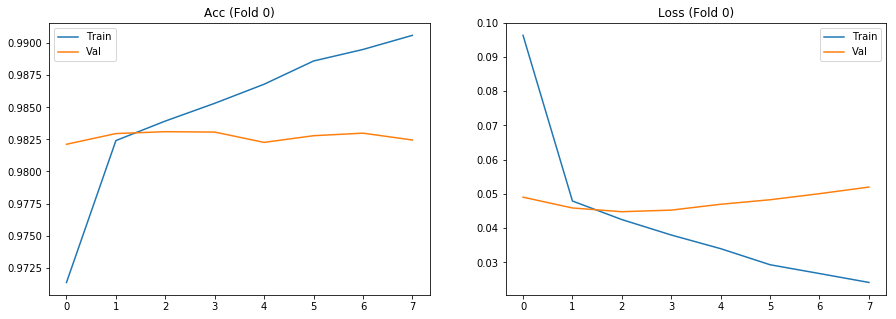

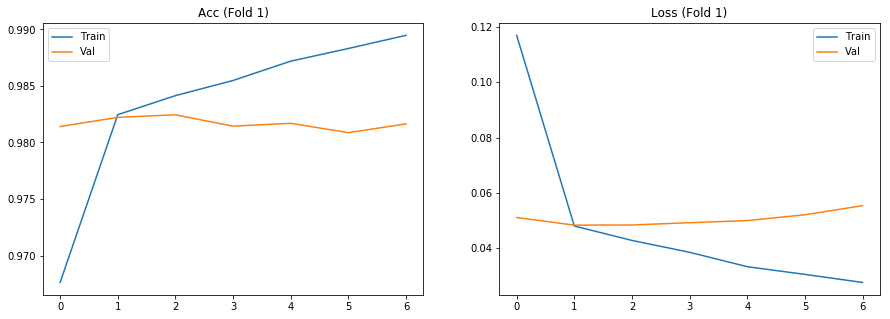

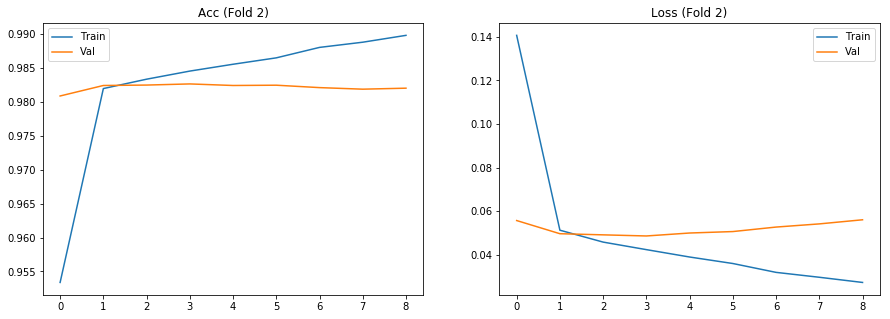

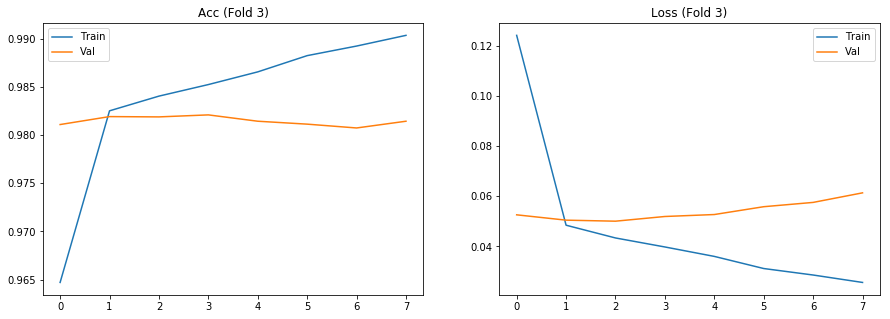

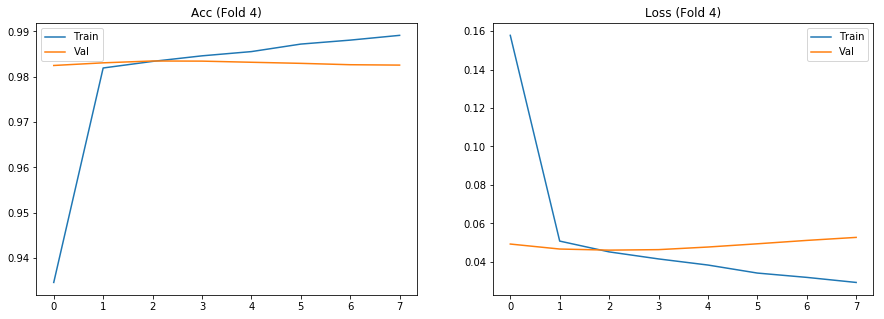

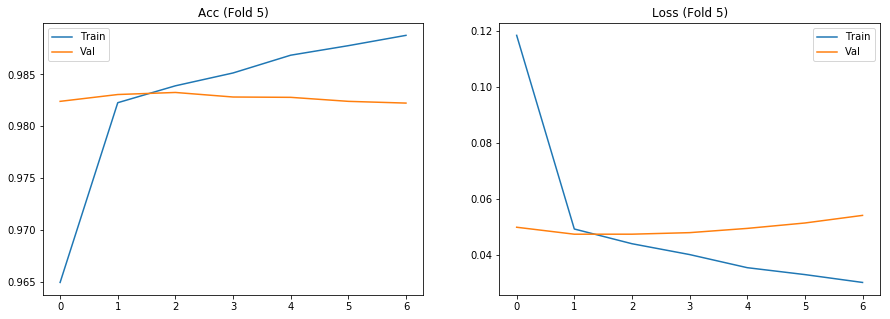

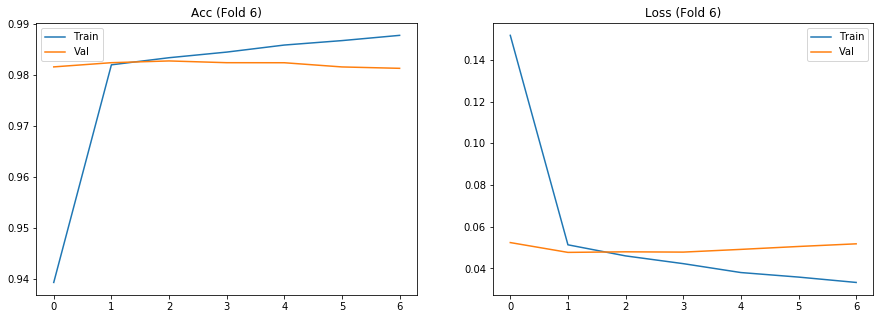

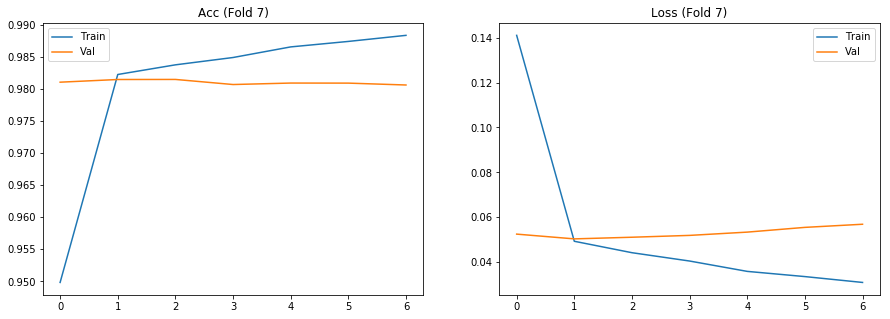

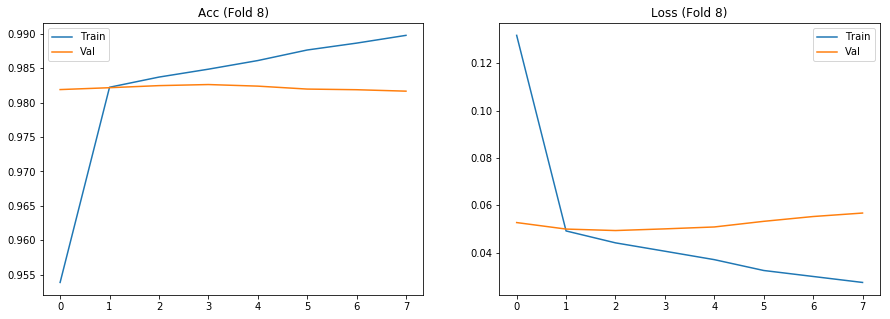

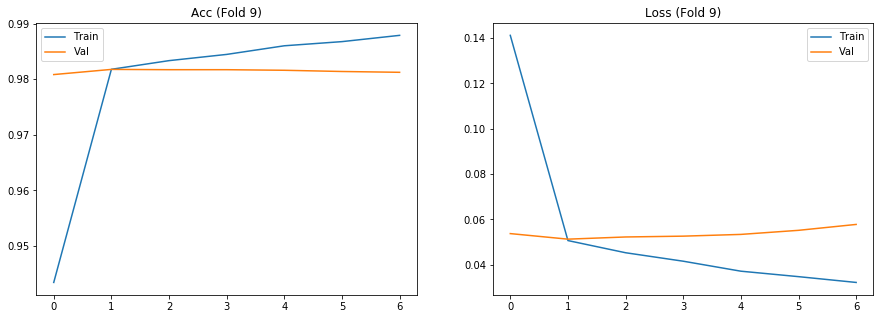

In [11]:
kfold_train(kfold, X_df, y_df, lstm_model, save_model_name)

In [12]:
# create prediction csv
model_predict(lstm_model, save_model_name, num_fold, X_test, list_class)
# release memory
del lstm_model
gc.collect()

Processing model 0 ...
Processing model 1 ...
Processing model 2 ...
Processing model 3 ...
Processing model 4 ...
Processing model 5 ...
Processing model 6 ...
Processing model 7 ...
Processing model 8 ...
Processing model 9 ...


In [10]:
save_model_name = 'biLSTM_attention'
lstm_attention_model = biLSTM_attention_model(embed_size, max_feature, max_len, embedding_matrix)

***************************************************
*******************   fold  0   *******************
***************************************************
model/biLSTM_attention_fold_0.model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          187392    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          99328     
_________________________________________________________________
attention_1 (Attention)      (None, 128)               228       
_________________________________________________________________
dense_1 (Dense) 

***************************************************
*******************   fold  3   *******************
***************************************************
model/biLSTM_attention_fold_3.model
Train on 143614 samples, validate on 15957 samples
Epoch 1/30
143614/143614 [==============================] - 60s 415us/step - loss: 0.1531 - acc: 0.9502 - val_loss: 0.0747 - val_acc: 0.9748

Epoch 00001: val_loss improved from inf to 0.07465, saving model to model/biLSTM_attention_fold_3.model
Epoch 2/30
143614/143614 [==============================] - 57s 400us/step - loss: 0.0548 - acc: 0.9806 - val_loss: 0.0501 - val_acc: 0.9820

Epoch 00002: val_loss improved from 0.07465 to 0.05011, saving model to model/biLSTM_attention_fold_3.model
Epoch 3/30
143614/143614 [==============================] - 57s 399us/step - loss: 0.0458 - acc: 0.9832 - val_loss: 0.0493 - val_acc: 0.9822

Epoch 00003: val_loss improved from 0.05011 to 0.04932, saving model to model/biLSTM_attention_fold_3.model
Epoch 4/30



Epoch 00007: val_loss did not improve from 0.04847

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/30
143614/143614 [==============================] - 57s 400us/step - loss: 0.0302 - acc: 0.9886 - val_loss: 0.0544 - val_acc: 0.9816

Epoch 00008: val_loss did not improve from 0.04847
Epoch 00008: early stopping
***************************************************
*******************   fold  7   *******************
***************************************************
model/biLSTM_attention_fold_7.model
Train on 143614 samples, validate on 15957 samples
Epoch 1/30
143614/143614 [==============================] - 60s 420us/step - loss: 0.1664 - acc: 0.9490 - val_loss: 0.1344 - val_acc: 0.9630

Epoch 00001: val_loss improved from inf to 0.13444, saving model to model/biLSTM_attention_fold_7.model
Epoch 2/30
143614/143614 [==============================] - 57s 400us/step - loss: 0.0786 - acc: 0.9720 - val_loss: 0.0558 - val_acc: 0.9800

Epoch 00002: va

ResourceExhaustedError: OOM when allocating tensor with shape[512,100,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_9/Adam/gradients/attention_1/mul_grad/Mul = Mul[T=DT_FLOAT, _class=["loc:@training_9/Adam/gradients/AddN_3"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_9/Adam/gradients/attention_1/Sum_1_grad/Tile, attention_1/ExpandDims)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


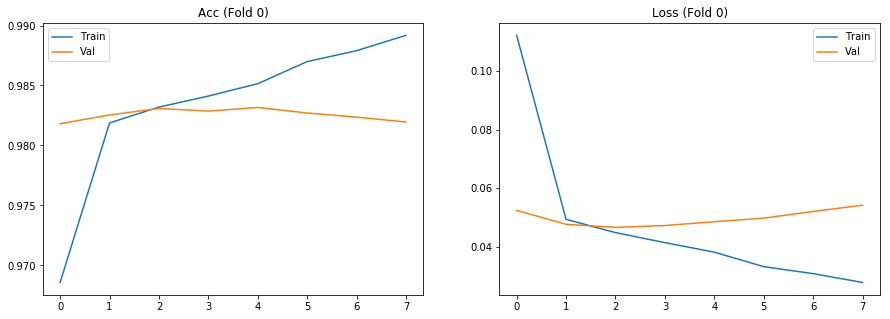

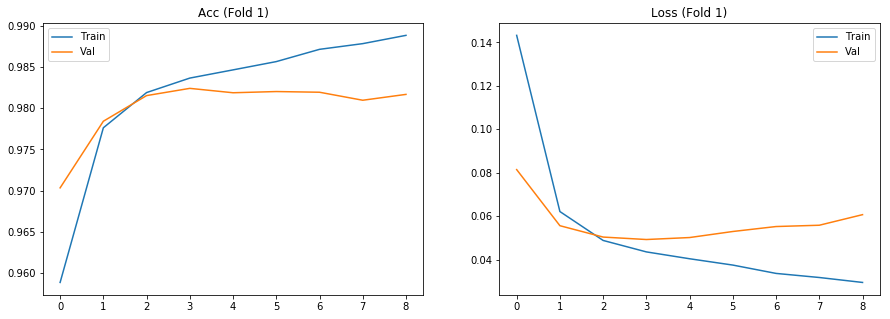

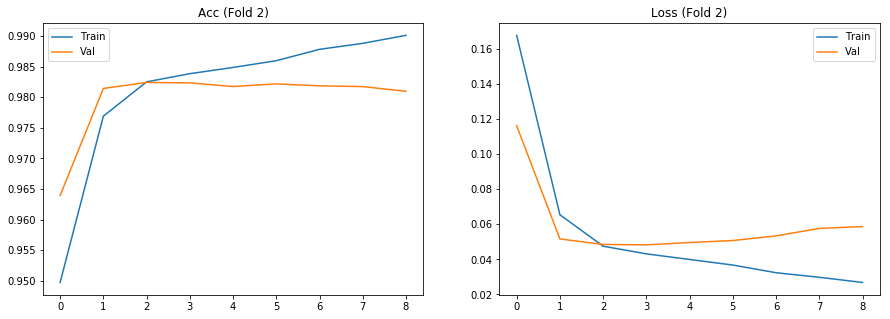

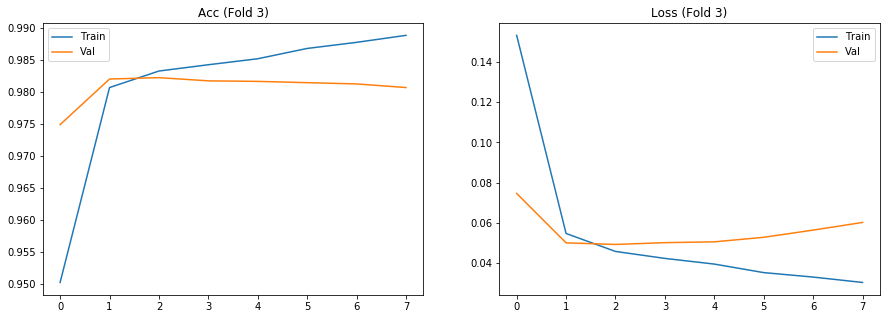

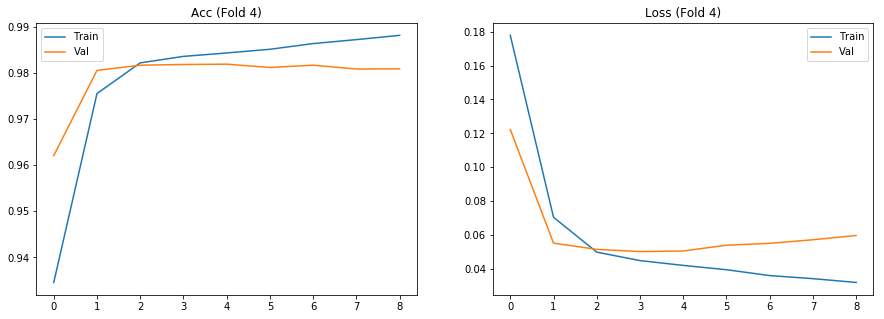

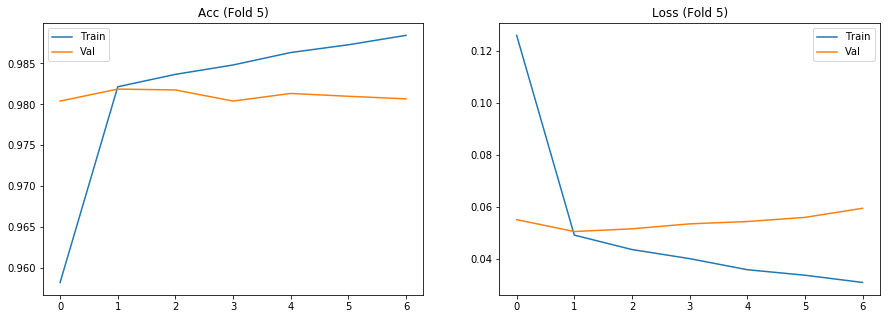

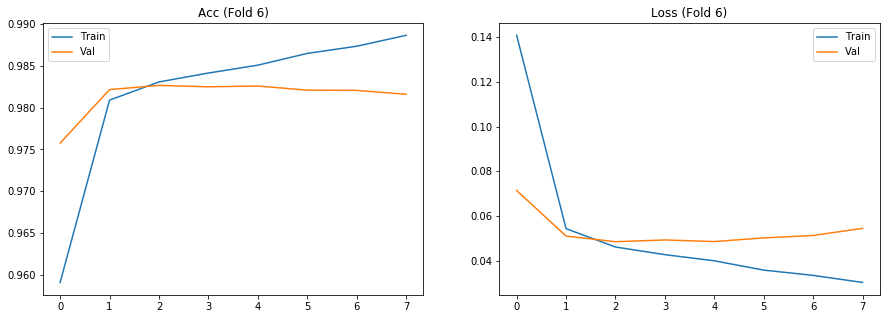

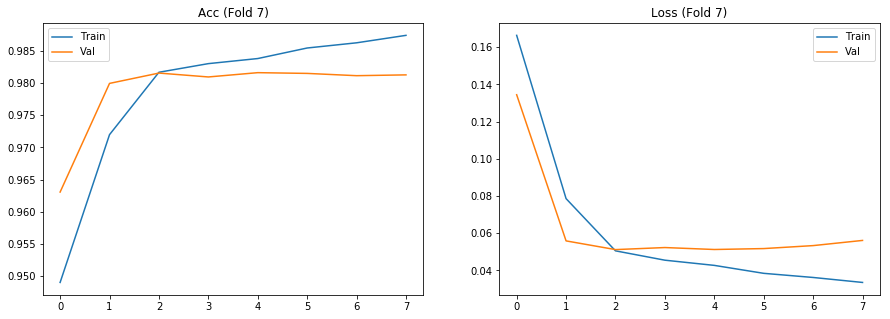

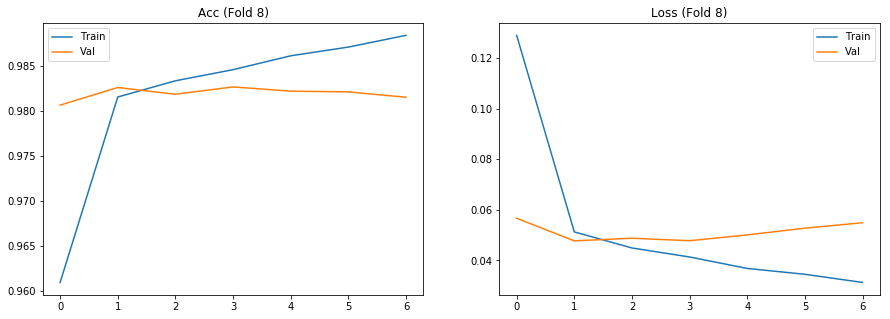

In [11]:
kfold_train(kfold, X_df, y_df, lstm_attention_model, save_model_name)

In [12]:
model_predict(lstm_attention_model, save_model_name, num_fold, X_test, list_class)

Processing model 0 ...
Processing model 1 ...
Processing model 2 ...
Processing model 3 ...
Processing model 4 ...
Processing model 5 ...
Processing model 6 ...
Processing model 7 ...
Processing model 8 ...
Processing model 9 ...
